# Deep Q-Networks (DQN)

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from IPython.display import display, clear_output
import random

import gymnasium as gym

from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.plots import *
from utils.models import *

## Config

In [19]:
CONFIG = {
    'DQN': {
        'hidden_sizes': [64, 64],
        'gamma': 0.99,
        'num_episodes': 1000,
        'lr': 0.0025,
        'learning_starts': 500,
        'max_buffer_size': 100_000,
        'batch_size': 128,
        'tau': 0.0005, 
        'epsilon_start': 1.0,
        'epsilon_end': 0.01,
        'epsilon_decay': 0.995,
    },
    'animation': {
        'FPS': None,
        'do_truncate': True,
    },
    'plots_info': {
        'subplt_shape': (1,2),
        'figsize': (12,4),
        'subplts_info': [
            {'key': "rewards",
            'title': "Smoothed Rewards",
            'xlabel': "Episodes",
            'ylabel': "Reward"},
            
            {'key': "q_loss",
            'title': "Smooth Action Value Function Loss",
            'xlabel': "Timesteps",
            'ylabel': "Loss"}
        ],
    },
}

## Creating the env

In [10]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

## DQN

In [11]:
def DQN(env, hidden_sizes = [32], gamma = 1.0, num_episodes = 1000, lr = 1e-2,
        learning_starts = 5000, max_buffer_size = 100_000, batch_size = 32,
        tau = 0.005, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):

    def get_eps_greedy_policy(Q, epsilon):
        def eps_greedy_policy(state):
            with torch.no_grad():
                Q_s = Q(state)
            A = np.ones(a_dims)*epsilon/a_dims
            A[np.argmax(Q_s)] += 1 - epsilon
            return A
        return eps_greedy_policy
    

    s_dims = env.observation_space.shape[0]
    a_dims = env.action_space.n
    
    stats = {'ep_length': [],
             'completions': 0,
             'q_loss': [],
             'rewards': []}

    Q = MLP(s_dims, a_dims, hidden_sizes)
    Q_target = MLP(s_dims, a_dims, hidden_sizes)
    Q_target.load_state_dict(Q.state_dict())

    loss_fn = nn.MSELoss()
    
    optimizer = torch.optim.AdamW(Q.parameters(), lr = lr)

    replay_buffer = deque(maxlen = max_buffer_size)
    
    epsilon = epsilon_start
    policy = get_eps_greedy_policy(Q, epsilon)

    n_steps = 0
    last_upd_steps = 0
    for e in range(1, num_episodes + 1):

        if e % 1 == 0 or e == num_episodes:
            print(f'\rEpisode : {e}/{num_episodes} ({100*e/num_episodes:.2f}%)', end = '')
            sys.stdout.flush()

        T = 0
        s, _ = env.reset()
        avg_qloss = 0.0
        reward_sum = 0.0
        while True:
            T += 1
            n_steps += 1
            
            probs = policy(torch.as_tensor(s))
            a = np.random.choice(list(range(a_dims)), p = probs)

            s_n, r, terminated, truncated, _ = env.step(a)
            reward_sum += r
            done = terminated or truncated

            # Deque automatically pops the oldest when the buffer size exceeds limit
            replay_buffer.append((s, a, r, s_n, done))

            
            if n_steps > learning_starts:
                batch = random.sample(replay_buffer, batch_size)
                
                s_batch = torch.FloatTensor(np.array([t[0] for t in batch]))
                a_batch = torch.LongTensor([t[1] for t in batch]).unsqueeze(1)
                r_batch = torch.FloatTensor([t[2] for t in batch])
                s_next_batch = torch.FloatTensor([t[3] for t in batch])
                done_batch = torch.FloatTensor([t[4] for t in batch])

                current_q = Q(s_batch).gather(1, a_batch)
                
                with torch.no_grad():
                    next_q = Q_target(s_next_batch).max(1)[0]
                    target_q = r_batch + gamma * next_q * (1 - done_batch)

                
                loss = loss_fn(current_q.squeeze(), target_q)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(Q.parameters(), 10)
                avg_qloss += loss.item() 
                optimizer.step()
                    
                Q_target_state_dict = Q_target.state_dict()
                Q_state_dict = Q.state_dict()
                for key in Q_state_dict:
                    Q_target_state_dict[key] = Q_state_dict[key]*tau + Q_target_state_dict[key]*(1-tau)
                Q_target.load_state_dict(Q_target_state_dict)
                    
            if done:
                stats['ep_length'] += [T]
                stats['rewards'].append(reward_sum)
                if truncated:
                    stats['completions'] += 1

                break
            
            s = s_n

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        
        policy = get_eps_greedy_policy(Q, epsilon)
        
        stats['q_loss'].append(avg_qloss / T)

        
    policy = get_eps_greedy_policy(Q, 0.0)
    return Q, policy, stats

In [29]:
Q, policy, stats = DQN(env, **CONFIG['DQN'])

Episode : 1000/1000 (100.00%)

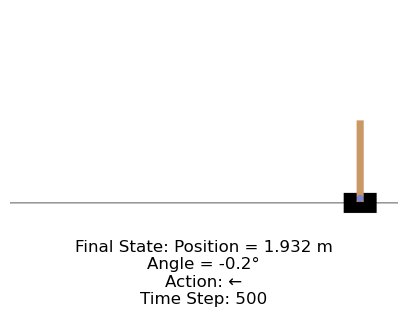

In [30]:
animate_policy(env, policy, None, True)

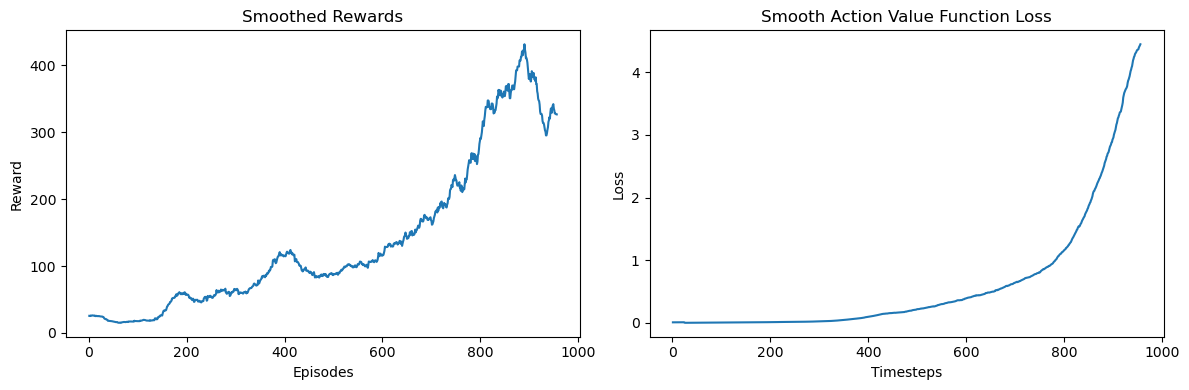

In [31]:
plot_stats(stats, CONFIG['plots_info'], 45)